In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import math


In [27]:
# Compute mean squared error for images `A` and `B`
# https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
def mse(A, B):
    assert(A.shape == B.shape), f"A ({A.shape}) B ({B.shape})"
    mse = (A.astype(np.float32) - B.astype(np.float32)) ** 2
    mse = np.mean(mse)
    return mse

# Compute Peak signal to noise ratio (PSNR) for images `A` and `B`
def psnr(A,B):
    assert(np.iinfo(A.dtype).bits == np.iinfo(B.dtype).bits)
    #peak = 2**(np.iinfo(np.uint8).bits) - 1
    peak = 255.0
    _mse = mse(A,B)
    if _mse == 0:
        return 0
    else:
        return 10 * math.log10(peak**2/_mse)

In [3]:
def box_filter(I, r):
    return cv2.blur(I, (2*r + 1, 2*r + 1))

def guided_filter(I_name, p_name, r, eps):
    
    I = cv2.imread(I_name).astype(float) / 255
    p = cv2.imread(p_name).astype(float) / 255
    
    mean_I  = box_filter(I  , r)
    mean_p  = box_filter(p  , r)
    corr_II = box_filter(I*I, r)
    corr_Ip = box_filter(I*p, r)
    
    var_I  = corr_II - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p
    
    a = cov_Ip / (var_I + eps ** 2)
    #print(var_I)
    b = mean_p - a * mean_I
    
    #cv2.imwrite('var_II.png', (var_I + eps ** 2) * 255)
    #cv2.imwrite('a.png', a * 255)
    
    mean_a = box_filter(a, r)
    mean_b = box_filter(b, r)
    
    q = mean_a * I + mean_b
    #print(a[0, :10, 0])
    
    cv2.imwrite('output.png', q * 255)
    

guided_filter("lena.jpg", "lena.jpg", 8, 0.05)

In [33]:
A = cv2.imread('cppGBTF.bmp')
#B = cv2.imread('laplacian_corrected.bmp')
B = cv2.imread('GBTF.bmp')
print(np.sum(np.abs(A - B)))

print(psnr(A, B))

937944060
52.35418325539568


In [5]:
#https://github.com/tt6746690/cv_project/blob/master/demosaicing/interpolation.py

from typing import Tuple

import cv2 as cv
import numpy as np

# Given full-res image `I`
#    Return indices to R,B,G channels according to the following pattern
#
#    R  G
#    G  B
# 
def bayer_idx(shape: Tuple[int,int]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert(len(shape) == 2)
    assert(all(np.array(shape) % 2 == np.zeros(2)))

    rsize = (np.array(shape) / 2).astype(np.int)
    
    rowix = np.arange(1,shape[0],2)[:,np.newaxis]
    colix = np.arange(1,shape[1],2)[np.newaxis,:]
    # a = [0, 1, 2]
    # tile: np.tile(a, (2, 2))
    #    array([[0, 1, 2, 0, 1, 2],
    #           [0, 1, 2, 0, 1, 2]])
    B_idx = np.tile(rowix, (1,rsize[1])), np.tile(colix, (rsize[0],1))

    # hstack: concatenation along the second axis, except for 1-D
    rowix = np.hstack((np.arange(1,shape[0],2)[:,np.newaxis], \
                       np.arange(0,shape[0],2)[:,np.newaxis]))
    colix = np.arange(0,shape[1])
    G_idx = np.tile(rowix, (1,rsize[1])), np.tile(colix, (rsize[0],1))

    rowix = np.arange(0,shape[0],2)[:,np.newaxis]
    colix = np.arange(0,shape[1],2)[np.newaxis,:]
    R_idx = np.tile(rowix, (1,rsize[1])), np.tile(colix, (rsize[0],1))
    
    return B_idx, G_idx, R_idx
    
# Get masks for bayer mosaics,
#     where `shape` is a 2-tuple
def bayer_mask(shape: Tuple[int,int]) -> np.ndarray:
    B_idx, G_idx, R_idx = bayer_idx(shape)
    mask = np.zeros((*shape, 3), dtype=np.uint8)

    mask[(*B_idx,0)] = 1
    mask[(*G_idx,1)] = 1
    mask[(*R_idx,2)] = 1

    return mask
    
# Downsampling `img` according to `RGGB` pattern
# 
def bayer_downsample(img: np.ndarray) -> np.ndarray:
    mask = bayer_mask(img.shape[:2])
    c = img * mask
    return c


# Split image into 3 channels according to bayer pattern
#       mxnx1 -> mxnx3
def bayer_split(img: np.ndarray) -> np.ndarray:
    assert(len(img.shape) == 2)
    
    shape = img.shape
    B_idx, G_idx, R_idx = bayer_idx(shape)

    out = np.zeros((*shape, 3), dtype=np.uint8)
    out[(*B_idx,0)] = img[B_idx]
    out[(*G_idx,1)] = img[G_idx]
    out[(*R_idx,2)] = img[R_idx]

    return out

In [19]:
# Smooth-hue Interpolation
#       https://patents.google.com/patent/US4642678A/en
#       https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1207407

# The algorithm
#   - interpolate `G`
#   - compute hue for `R`,`B` channels at subsampled locations
#   - interpolate hue for all pixels in `R`,`B` channels
#   - determine chrominance `R`,`B` from hue
# 
def demosaic_smooth_hue(img: np.ndarray, log_space=True) -> np.ndarray:
    assert(len(img.shape) in [2,3])

    if len(img.shape) == 2:
        img = bayer_split(img)

    K_B = 1/4 * np.array([ [1,2,1], [2,4,2], [1,2,1] ])
    K_G = 1/4 * np.array([ [0,1,0], [1,4,1], [0,1,0] ])
    K_R = K_B

    interp = img.copy().astype(np.float32) / 255.
    B_idx, G_idx, R_idx = bayer_idx(interp.shape[:2])

    # interpolate luminance G
    interp[:,:,1] = cv.filter2D(interp[:,:,1], cv.CV_32F, K_G)
    
    # compute hue B: [:,:,0] R: [:,:,1]
    hue = np.zeros((*interp.shape[:2],2), dtype=np.float32)
    if log_space:
        hue[(*B_idx,0)] = interp[(*B_idx,0)] - interp[(*B_idx,1)]
        hue[(*R_idx,1)] = interp[(*R_idx,2)] - interp[(*R_idx,1)]
    else:
        interp[(*B_idx,1)] += np.finfo(np.float32).eps
        interp[(*R_idx,1)] += np.finfo(np.float32).eps
        hue[(*B_idx,0)] = interp[(*B_idx,0)] / interp[(*B_idx,1)]
        hue[(*R_idx,1)] = interp[(*R_idx,2)] / interp[(*R_idx,1)]

    # interpolate hue
    hue[:,:,0] = cv.filter2D(hue[:,:,0], cv.CV_32F, K_B)
    hue[:,:,1] = cv.filter2D(hue[:,:,1], cv.CV_32F, K_R)

    # Compute chrominance B,R
    if log_space:
        #clip: 超過 min~max 的值會變成 min~max
        interp[:,:,0] = np.clip(hue[:,:,0] + interp[:,:,1],0,1) 
        interp[:,:,2] = np.clip(hue[:,:,1] + interp[:,:,1],0,1)
    else:
        interp[:,:,0] = np.clip(hue[:,:,0] * interp[:,:,1],0,1)
        interp[:,:,2] = np.clip(hue[:,:,1] * interp[:,:,1],0,1)

    interp = (interp*255).astype(np.uint8)

    return interp


# Laplacian-corrected linear filter (MATLAB's demosaic)
#       https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1326587
#       https://www.ipol.im/pub/art/2011/g_mhcd/article.pdf
# 
def demosaic_laplacian_corrected(img, gain_factors=(1/2,5/8,3/4)):
    assert(len(img.shape) in [2,3])

    if len(img.shape) == 2:
        img = bayer_split(img)
        
    alpha,beta,gamma = gain_factors

    K_L = 1/4 * np.array([
        [0,0,-1,0,0],
        [0,0,0,0,0],
        [-1,0,4,0,-1],
        [0,0,0,0,0],
        [0,0,-1,0,0],
    ])

    K_B = 1/4 * np.array([ [1,2,1], [2,4,2], [1,2,1] ])
    K_G = 1/4 * np.array([ [0,1,0], [1,4,1], [0,1,0] ])
    K_R = K_B

    interp = img.copy().astype(np.float32) / 255.
    laplacian = interp.copy()
    B_idx, G_idx, R_idx = bayer_idx(interp.shape[:2])

    # Interpolate R,G,B
    interp[:,:,0] = cv.filter2D(interp[:,:,0], cv.CV_32F, K_B)
    interp[:,:,1] = cv.filter2D(interp[:,:,1], cv.CV_32F, K_G)
    interp[:,:,2] = cv.filter2D(interp[:,:,2], cv.CV_32F, K_R)

    # Compute discrete laplacian in 5x5 neighborhood
    laplacian[:,:,0] = cv.filter2D(laplacian[:,:,0], cv.CV_32F, K_L)
    laplacian[:,:,1] = cv.filter2D(laplacian[:,:,1], cv.CV_32F, K_L)
    laplacian[:,:,2] = cv.filter2D(laplacian[:,:,2], cv.CV_32F, K_L)

    # Laplacian correction
    # Green
    interp[(*R_idx,1)] = interp[(*R_idx,1)] + alpha*laplacian[(*R_idx,2)]
    interp[(*B_idx,1)] = interp[(*B_idx,1)] + alpha*laplacian[(*B_idx,0)]
    # Red
    interp[(*G_idx,2)] = interp[(*G_idx,2)] + beta*laplacian[(*G_idx,1)]
    interp[(*B_idx,2)] = interp[(*B_idx,2)] + beta*laplacian[(*B_idx,0)]
    # Blue
    interp[(*G_idx,0)] = interp[(*G_idx,0)] + gamma*laplacian[(*G_idx,1)]
    interp[(*R_idx,0)] = interp[(*R_idx,0)] + gamma*laplacian[(*R_idx,2)]

    interp = (np.clip(interp*255,0,255)).astype(np.uint8)

    return interp

In [6]:
def color_interpolation(pic):
    """
    BayerBG:
        R  G  R  G
        G  B  G  B
        R  G  R  G
        G  B  G  B
        
        [2464][3280]
        主要為 Lab DC Contest 的簡單演算法
        https://blog.csdn.net/j_d_c/article/details/54019582 另可參考所說的演算法
    """
    rows = 2464
    columns = 3280
    
    pic = pic.astype(np.uint32)
    
    r = np.zeros(shape=(rows, columns))
    g = np.zeros(shape=(rows, columns))
    b = np.zeros(shape=(rows, columns))
    # Red 
    for i in range(0, rows, 2):
        for j in range(0, columns, 2):
            r[i][j] = pic[i][j]
            
            #藍色在斜的四方
            #綠色上下左右
            if i == 0:
                g[i][j] = pic[i+1][j]
            else:
                g[i][j] = ( pic[i-1][j] + pic[i+1][j] )//2 #左右/2
            
            if i == 0 and j == 0:
                b[i][j] = pic[i+1][j+1]
            elif j == 0:
                b[i][j] = ( pic[i-1][j+1] + pic[i+1][j+1] )// 2
            elif i == 0:
                b[i][j] = ( pic[i+1][j-1] + pic[i+1][j+1] )// 2
            else:
                b[i][j] = ( pic[i-1][j-1] + pic[i-1][j+1] + pic[i+1][j-1] + pic[i+1][j+1] )// 4
    # Green
    for i in range(1, rows, 2): # i can -1
        for j in range(0, columns, 2):
            g[i][j] = pic[i][j]
            
            if i + 1 >= rows:
                r[i][j] = pic[i-1][j]
            else:
                r[i][j] = ( pic[i-1][j] + pic[i+1][j] )//2 #紅色在上下
            
            if j == 0:
                b[i][j] = pic[i][j+1]
            elif j + 1 >= columns:
                b[i][j] = pic[i][j-1]
            else:
                b[i][j] = ( pic[i][j-1] + pic[i][j+1] )//2 #藍色在左右
    
    # Another Green
    for i in range(0, rows, 2):
        for j in range(1, columns, 2): # j can -1
            g[i][j] = pic[i][j]
            
            if j + 1 >= columns:
                r[i][j] = pic[i][j-1]
            else:
                r[i][j] = ( pic[i][j-1] + pic[i][j+1] )//2 #紅色在左右
                
            if i == 0:
                b[i][j] = pic[i + 1][j]
            else:
                b[i][j] = ( pic[i-1][j] + pic[i+1][j] )//2 #藍色在上下
    
    # Blue 
    for i in range(1, rows, 2):
        for j in range(1, columns, 2):
            b[i][j] = pic[i][j]
            
            #紅色在斜的四方
            #綠色上下左右
            if i + 1 >= rows and j + 1 >= columns:
                r[i][j] = pic[i-1][j-1]
                g[i][j] = pic[i][j-1]
            elif i + 1 >= rows:
                r[i][j] = ( pic[i-1][j-1] + pic[i-1][j+1] )//2
                g[i][j] = ( pic[i][j-1] + pic[i][j+1] )/2
            elif j + 1 >= columns:
                r[i][j] = ( pic[i-1][j-1] + pic[i+1][j-1] )//2
                g[i][j] = pic[i][j-1]
            else:
                r[i][j] = ( pic[i-1][j-1] + pic[i-1][j+1] + pic[i+1][j-1] + pic[i+1][j+1] )//4
                g[i][j] = ( pic[i][j-1] + pic[i][j+1] )//2
    
    r = r.reshape( (rows, columns, -1))
    g = g.reshape( (rows, columns, -1))
    b = b.reshape( (rows, columns, -1))
    img = np.concatenate((r, np.concatenate((g, b), 2)), 2)
    return img.astype(np.uint8)


In [ ]:
"""
    NB Color interpolation算法是吃2ByteRaw10 = 16bit的raw格式。 
    放大後如下: 排列為LH, 黑色區為bit8和bit9高位元。白色為bit0~bit7低位元，共10bits. 
    [0~7][8&9] = 1 number, 問題 low -> high 但 read 是從 high -> low
"""
#https://stackoverflow.com/questions/4516365/reading-raw-imagery-with-pil-and-python
rows = 2464
columns = 6560

#https://www.tutorialsteacher.com/python/python-read-write-file, 以 binary format 讀取
#https://stackoverflow.com/questions/10689748/how-to-read-bits-from-a-file, 至少一個 bytes
scene_infile = open("NB_10MA.raw",'rb')
scene_image_array = np.fromfile(scene_infile, dtype=np.uint8, count=rows*columns)
scene_image = Image.frombuffer("I",[columns, rows],
                               scene_image_array.astype('I'),
                               'raw','I',0,1)

In [ ]:
scene_image.show()

In [ ]:
rawImage = scene_image_array.reshape((rows, columns))

# https://stackoverflow.com/questions/1987694/how-to-print-the-full-numpy-array-without-truncation
# to print full np.array
with np.printoptions(threshold=np.inf): 
    print(rawImage[:4, :4])
with np.printoptions(threshold=np.inf): 
    print(rawImage[16:32, 0:8])

In [ ]:
"""
    排列為LH, 黑色區為bit8和bit9高位元。白色為bit0~bit7低位元，共10bits. 
"""
bitmaps = np.unpackbits(rawImage.reshape((rows, columns, -1)), axis=-1)

print(bitmaps.shape) #2464, 6560 * 8 
with np.printoptions(threshold=np.inf): 
    print(bitmaps[28:32, :8])

In [15]:
#https://stackoverflow.com/questions/4516365/reading-raw-imagery-with-pil-and-python
"""
rows = 2464
columns = 6560 // 2
"""
#new raw files
rows = 3072;
columns = 4096;

#fileName = "NB_10MA.raw"
#fileName = "./1/raw16_4096X3072.16_rggb_raw"
#fileName = "./2/raw16_4096X3072.16_rggb_raw"
fileName = "./3/raw16_4096X3072.16_rggb_raw"

#https://www.tutorialsteacher.com/python/python-read-write-file, 以 binary format 讀取
#https://stackoverflow.com/questions/10689748/how-to-read-bits-from-a-file, 至少一個 bytes
scene_infile = open(fileName,'rb')
scene_image_array = np.fromfile(scene_infile, dtype=np.uint16, count=rows*columns)
#https://stackoverflow.com/questions/25267089/convert-a-two-byte-uint8-array-to-a-uint16-in-swift
#如何讀取跟字節序有關? 小端序 0x0102 => [0x02][0x01] -> increasing addresses
scene_image = Image.frombuffer("I",[columns, rows],
                               scene_image_array.astype('I'),
                               'raw','I',0,1)

In [6]:
scene_image.show()

In [16]:
#16 bit -> 0~65535
scene_image_array = scene_image_array.reshape((rows, columns))
print(np.max(scene_image_array))
with np.printoptions(threshold=np.inf): 
    print(scene_image_array[16:32, 0:8])

scene_image_array = scene_image_array.astype(np.float64)
scene_image_array *= (255.0 / 1023.0)
scene_image_array = scene_image_array.astype(np.uint8)
"""
[[ 90   0 124   0  89   0 117   0]
 [126   0 102   0 127   0 104   0]
 [ 96   0 129   0  99   0 132   0]
 [144   0 115   0 143   0 114   0]
 [103   0 153   0 103   0 155   0]
 [176   0 138   0 171   0 133   0]
 [141   0 209   0 148   0 198   0]
 [ 37   1 187   0  15   1 178   0]
 [222   0 141   1 215   0 117   1]
 [191   1  47   1 189   1  40   1]
 [  0   1 230   1 252   0 245   1]
 [251   1 123   1 254   1 107   1]
 [ 16   1   9   2   3   1  11   2]
 [ 10   2 145   1   2   2 134   1]
 [  5   1  22   2 248   0   8   2]
 [254   1 144   1 254   1 152   1]]
"""

1023
[[122 254 122 247 122 242 119 240]
 [248 133 250 137 251 134 243 133]
 [118 247 124 255 121 240 121 247]
 [239 133 247 133 248 134 248 134]
 [119 237 119 247 121 251 124 244]
 [247 132 238 135 242 134 247 135]
 [118 240 116 236 122 250 121 252]
 [241 134 241 133 248 133 248 134]
 [118 242 119 238 122 247 121 247]
 [239 135 247 130 244 132 244 132]
 [122 247 124 247 121 249 118 241]
 [244 131 253 133 252 135 241 133]
 [120 256 123 254 117 247 119 246]
 [251 133 255 136 245 129 244 135]
 [121 244 124 252 119 248 120 246]
 [242 135 246 136 246 134 241 134]]


'\n[[ 90   0 124   0  89   0 117   0]\n [126   0 102   0 127   0 104   0]\n [ 96   0 129   0  99   0 132   0]\n [144   0 115   0 143   0 114   0]\n [103   0 153   0 103   0 155   0]\n [176   0 138   0 171   0 133   0]\n [141   0 209   0 148   0 198   0]\n [ 37   1 187   0  15   1 178   0]\n [222   0 141   1 215   0 117   1]\n [191   1  47   1 189   1  40   1]\n [  0   1 230   1 252   0 245   1]\n [251   1 123   1 254   1 107   1]\n [ 16   1   9   2   3   1  11   2]\n [ 10   2 145   1   2   2 134   1]\n [  5   1  22   2 248   0   8   2]\n [254   1 144   1 254   1 152   1]]\n'

In [21]:
result = demosaic_smooth_hue(scene_image_array)
cv2.imwrite("smooth_hue.bmp", result)
result = demosaic_laplacian_corrected(scene_image_array)
cv2.imwrite("laplacian_corrected.bmp", result)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.11274509  0.         -0.10980392  0.         -0.10686274
   0.         -0.10588235]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.10588235  0.         -0.1117647   0.         -0.10882352
   0.         -0.10980392]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.10784313  0.         -0.10392156  0.         -0.11078431
   0.         -0.11078431]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.10490195  0.         -0.10392156  0.         -0.11078431
   0.         -0.1117647 ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.10686274  0.         -0.11078431  0.         -0.11274509
   0.         -0.1117647 ]
 [ 0.          0.          0. 

True

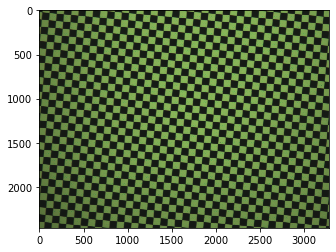

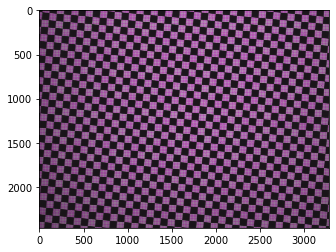

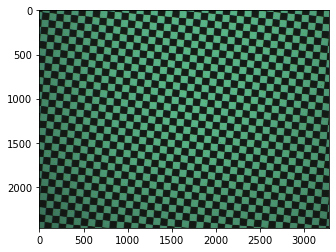

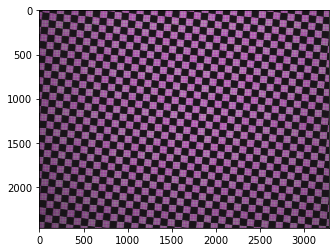

In [8]:
#opencv 使用 4 way linear interpolation
#https://stackoverflow.com/questions/11890955/what-algorithm-does-opencvs-bayer-conversion-use
convertedImage = cv2.cvtColor(scene_image_array, cv2.COLOR_BAYER_BG2BGR)
plt.imshow(convertedImage)
plt.show()
cv2.imwrite("bayerBG.bmp", convertedImage)
convertedImage = cv2.cvtColor(scene_image_array, cv2.COLOR_BAYER_GB2BGR)
plt.imshow(convertedImage)
plt.show()
convertedImage = cv2.cvtColor(scene_image_array, cv2.COLOR_BAYER_RG2BGR)
plt.imshow(convertedImage)
plt.show()
cv2.imwrite("bayerRG.bmp", convertedImage)
convertedImage = cv2.cvtColor(scene_image_array, cv2.COLOR_BAYER_GR2BGR)
plt.imshow(convertedImage)
plt.show()

In [7]:
result = color_interpolation(scene_image_array)

In [5]:
target = cv2.imread("NB_10MA.bmp")

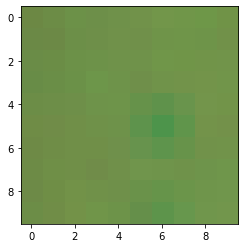

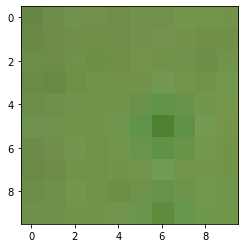

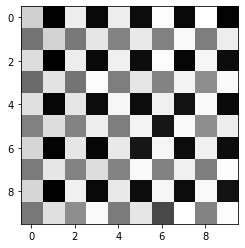

[[136  70 145  73 145  74 150  73 151  71]
 [107 137 108 143 112 144 111 149 110 145]
 [140  70 145  73 146  74 150  72 148  74]
 [104 142 107 150 110 143 112 147 115 149]
 [141  72 143  74 148  74 146  76 149  73]
 [111 140 112 145 110 147  77 149 115 145]
 [138  71 143  72 144  77 148  74 146  74]
 [109 143 112 140 112 149 111 146 110 150]
 [138  70 146  73 144  74 148  74 149  76]
 [108 141 115 149 109 143  93 151 112 150]]


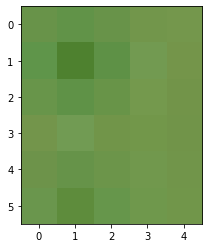

[ 77 148  75]
[ 78 129  47]
[[[110 147  74]
  [111 143  74]
  [112 147  74]
  [114 147  74]
  [115 148  74]]

 [[110 148  74]
  [102 146  74]
  [ 95 146  75]
  [105 148  76]
  [115 149  75]]

 [[110 146  74]
  [ 94 147  76]
  [ 77 148  75]
  [ 96 149  75]
  [115 147  74]]

 [[111 144  75]
  [103 147  77]
  [ 94 148  76]
  [103 147  74]
  [113 146  74]]

 [[112 144  74]
  [112 149  76]
  [111 148  75]
  [111 146  74]
  [110 148  75]]]
[[[115 147  74]
  [115 147  75]
  [115 152  81]
  [114 149  75]
  [111 147  72]]

 [[113 148  74]
  [104 147  73]
  [ 97 147  72]
  [104 147  73]
  [114 150  75]]

 [[110 151  77]
  [ 95 149  74]
  [ 78 129  47]
  [ 94 145  70]
  [114 154  81]]

 [[113 149  73]
  [104 149  74]
  [ 95 146  71]
  [104 148  72]
  [116 153  77]]

 [[113 147  74]
  [115 149  75]
  [113 155  83]
  [113 149  73]
  [114 151  74]]]


In [9]:
plt.imshow(convertedImage[320:330,345:355, :])
plt.show()
plt.imshow(target[320:330,345:355, :])
plt.show()
plt.imshow(scene_image_array[320:330,345:355], cmap='gray')
plt.show()
print( scene_image_array[320:330,345:355] )

plt.imshow(target[324:330,350:355, :]) #325 -> 1, 351 ->1 (2*162 + 1, 2*175 + 1)
plt.show()

print(convertedImage[325][351])
print(target[325][351])

print(convertedImage[323:328, 349:354, :])
print(target[323:328, 349:354, :])

# (r, g, b)
# 64 163 102 (紅色更少、綠色更少)
# 87 176 103

In [15]:
a = np.array([[[1], [2]]])
b = np.array([[[3], [4]]])
c = np.array([[[5], [6]]])
print( np.concatenate((a, np.concatenate((b, c), 2)), 2) )
print( np.concatenate((a, np.concatenate((b, c), 2)), 2).shape )

[[[1 3 5]
  [2 4 6]]]
(1, 2, 3)
